# Check the SARIMA prediction for every store




In [137]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly

In [138]:
# Loading the data

newtrain = pd.read_csv('data/newtrain.csv')
validation = pd.read_csv('data/validation.csv')

/opt/anaconda3/envs/minicomp/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [99]:
newtrain.head()

,Unnamed: 0,Date,Store,DayOfWeek,Sales,Open,Promo,StateHoliday,SchoolHoliday
0,27,2013-01-01,353.0,2.0,3139.0,1.0,0.0,a,1.0
1,115,2013-01-01,335.0,2.0,2401.0,1.0,0.0,a,1.0
2,147,2013-01-01,512.0,2.0,2646.0,1.0,0.0,a,1.0
3,162,2013-01-01,494.0,2.0,3113.0,1.0,0.0,a,1.0
4,199,2013-01-01,530.0,2.0,2907.0,1.0,0.0,a,1.0


In [139]:
# length of the series

l_newtrain = len(newtrain)
l_validation = len(validation)

In [140]:
# checking missing values in Store

newtrain.loc[newtrain['Store'].isnull(), 'Store']

91       NaN
120      NaN
125      NaN
177      NaN
180      NaN
          ..
435759   NaN
435762   NaN
435773   NaN
435794   NaN
435805   NaN
Name: Store, Length: 13246, dtype: float64

In [101]:
# removing for the moment columns with no ID

newtrain_rem = newtrain.drop(newtrain.loc[newtrain['Store'].isnull(), :].index, axis=0)  

In [141]:
# number of different stores

len(newtrain_rem['Store'].unique())

1115

In [104]:
# checking behavior of one store sales
store_index = newtrain_rem['Store'].unique()

store1 = newtrain_rem.loc[newtrain_rem['Store']==store_index[0], 'Sales']
date1 = newtrain_rem.loc[newtrain_rem['Store']==store_index[0], 'Date']

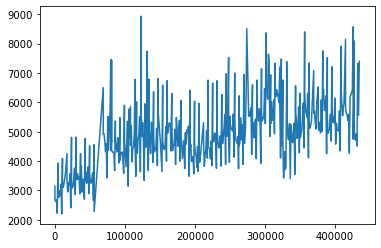

In [143]:
# sales for one store over time
plt.plot(store1)
plt.show()

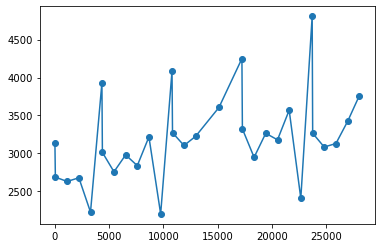

In [148]:
# plot in one month, it shows season of 7 days
plt.plot(store1[:30], '-o')
plt.show()

In [107]:
# importing packages for Sarima

from statsmodels.tsa.arima.model import ARIMA,ARIMAResults
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from pmdarima import auto_arima # on order to determine ARIMA orders
from statsmodels.tsa.stattools import adfuller


In [167]:
# define evaluation metrics

def metric(preds, actuals):
    print(type(preds))
    print(type(actuals))
    preds = preds.reshape(-1)
    actuals = actuals.reshape(-1)
    assert preds.shape == actuals.shape
    return 100 * np.linalg.norm((actuals - preds) / actuals) / np.sqrt(preds.shape[0])

In [171]:
# SARIMA best model for every store

model_dict = {}
pred = []

for i in range(len(store_index)):
    store = newtrain_rem.loc[newtrain_rem['Store']==store_index[i], 'Sales']
    best_model = auto_arima(store, suppress_warnings=True, start_p=0, start_q=0, m=7)
    
    model_dict[store_index[i]] = (best_model.order, best_model.seasonal_order)
    pred.append(best_model.predict(start=l_newtrain+1, end=l_validation, 
                              dynamic=False, typ='levels'))

/opt/anaconda3/envs/minicomp/lib/python3.9/site-packages/pmdarima/arima/_auto_solvers.py:522: ModelFitWarning: Error fitting  ARIMA(2,0,0)(2,0,1)[7] intercept (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most recent call last):
  File "/opt/anaconda3/envs/minicomp/lib/python3.9/site-packages/pmdarima/arima/_auto_solvers.py", line 506, in _fit_candidate_model
    fit.fit(y, X=X, **fit_params)
  File "/opt/anaconda3/envs/minicomp/lib/python3.9/site-packages/pmdarima/arima/arima.py", line 597, in fit
    self._fit(y, X, **fit_args)
  File "/opt/anaconda3/envs/minicomp/lib/python3.9/site-packages/pmdarima/arima/arima.py", line 518, in _fit
    fit, self.arima_res_ = _fit_wrapper()
  File "/opt/anaconda3/envs/minicomp/lib/python3.9/site-packages/pmdarima/arima/arima.py", line 508, in _fit_wrapper
    return arima, arima.fit(start_params=start_params,
  File "/opt/anaconda3/envs/minicomp/lib/python3.9/site-packages/statsmodels/tsa/statespa

/opt/anaconda3/envs/minicomp/lib/python3.9/site-packages/pmdarima/arima/_auto_solvers.py:522: ModelFitWarning: Error fitting  ARIMA(2,0,0)(2,0,1)[7] intercept (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most recent call last):
  File "/opt/anaconda3/envs/minicomp/lib/python3.9/site-packages/pmdarima/arima/_auto_solvers.py", line 506, in _fit_candidate_model
    fit.fit(y, X=X, **fit_params)
  File "/opt/anaconda3/envs/minicomp/lib/python3.9/site-packages/pmdarima/arima/arima.py", line 597, in fit
    self._fit(y, X, **fit_args)
  File "/opt/anaconda3/envs/minicomp/lib/python3.9/site-packages/pmdarima/arima/arima.py", line 518, in _fit
    fit, self.arima_res_ = _fit_wrapper()
  File "/opt/anaconda3/envs/minicomp/lib/python3.9/site-packages/pmdarima/arima/arima.py", line 508, in _fit_wrapper
    return arima, arima.fit(start_params=start_params,
  File "/opt/anaconda3/envs/minicomp/lib/python3.9/site-packages/statsmodels/tsa/statespa

/opt/anaconda3/envs/minicomp/lib/python3.9/site-packages/pmdarima/arima/_auto_solvers.py:522: ModelFitWarning: Error fitting  ARIMA(3,0,0)(2,0,1)[7] intercept (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most recent call last):
  File "/opt/anaconda3/envs/minicomp/lib/python3.9/site-packages/pmdarima/arima/_auto_solvers.py", line 506, in _fit_candidate_model
    fit.fit(y, X=X, **fit_params)
  File "/opt/anaconda3/envs/minicomp/lib/python3.9/site-packages/pmdarima/arima/arima.py", line 597, in fit
    self._fit(y, X, **fit_args)
  File "/opt/anaconda3/envs/minicomp/lib/python3.9/site-packages/pmdarima/arima/arima.py", line 518, in _fit
    fit, self.arima_res_ = _fit_wrapper()
  File "/opt/anaconda3/envs/minicomp/lib/python3.9/site-packages/pmdarima/arima/arima.py", line 508, in _fit_wrapper
    return arima, arima.fit(start_params=start_params,
  File "/opt/anaconda3/envs/minicomp/lib/python3.9/site-packages/statsmodels/tsa/statespa

KeyboardInterrupt: 

In [ ]:
validation_rem = validation.drop(validation.loc[validation['Store'].isnull(), :].index, axis=0)  
store1 = newtrain_rem.loc[newtrain_rem['Store']==store_index[0], 'Sales']

In [170]:
metric_store = []

for i in range(len(pred)):
    metric_store.append(metric(pred[i], 
                        np.array(validation_rem.loc[ validation_rem.loc[validation_rem['Store']==store_index[0], 'Sales'] ,'Sales'])))



<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


5888.972419790323

In [174]:
validation['Store'].isnull().any()

True